# The Materials API

### Presented by: John Dagdelen
### Assisted by: Rachel Woods-Robinson

In this lesson, we will learn how to interact with the Materials Project database and go through some practical examples of combining our own code with MP data to uncover new materials insights. We will do this through the Materials API (MAPI), which is an open API for accessing Materials Project data based on [Representational state transfer (REST)](https://en.wikipedia.org/wiki/Representational_state_transfer) principles.

In this module, we cover:

* The Materials Project API (MAPI).
* Getting your Materials Project API key.
* The `MPRester.query` method for accessing the MP database.
* A hands-on example of using the API and pymatgen to screen the database for interesting materials.
* The [mapidoc](https://github.com/materialsproject/mapidoc) (Materials Project documentation) repository.

***
## Section 0: Getting an API key

The first step to getting started with the API is to get an API key. API keys are unique identifiers that are used to track and control how the API is being used. 

To get yours, go to the dashboard page on the Materials Project website (https://materialsproject.org/dashboard). Click the 'Generate API key' button and copy the string under the button; this is your API key.

Paste your key in the line below, which will assign it the environment variable name MAPI_KEY.

In [ ]:
!pmg config --add PMG_MAPI_KEY <your API key>

***
## Section 1: Basic Queries In the Web Browser

To request data from the Materials Project, you will need to make requests to our API. To do this, you could simply make a GET request through your web browser, providing your API key as an argument. 

For example, 

``` https://www.materialsproject.org/rest/v2/materials/mp-1234/vasp?API_KEY=<your api key> ```

returns the following JSON document:
```
{"response": [{"energy": -26.94573468, "energy_per_atom": -4.49095578, "volume": 116.92375473740876, "formation_energy_per_atom": -0.4835973866666663, "nsites": 6, "unit_cell_formula": {"Al": 4.0, "Lu": 2.0}, "pretty_formula": "LuAl2", "is_hubbard": false, "elements": ["Al", "Lu"], "nelements": 2, "e_above_hull": 0, "hubbards": {}, "is_compatible": true, "spacegroup": {"source": "spglib", "symbol": "Fd-3m", "number": 227, "point_group": "m-3m", "crystal_system": "cubic", "hall": "F 4d 2 3 -1d"}, "task_ids": ["mp-1234", "mp-925833", "mp-940234", "mp-940654"], "band_gap": 0.0, "density": 6.502482433523648, "icsd_id": null, "icsd_ids": [608375, 57958, 608376, 608372, 608371, 608370], "cif": "# generated using pymatgen\ndata_LuAl2\n_symmetry_space_group_name_H-M   'P 1'\n_cell_length_a   5.48873905\n_cell_length_b   5.48873905\n_cell_length_c   5.48873905\n_cell_angle_alpha   60.00000005\n_cell_angle_beta   60.00000003\n_cell_angle_gamma   60.00000007\n_symmetry_Int_Tables_number   1\n_chemical_formula_structural   LuAl2\n_chemical_formula_sum   'Lu2 Al4'\n_cell_volume   116.92375474\n_cell_formula_units_Z   2\nloop_\n _symmetry_equiv_pos_site_id\n _symmetry_equiv_pos_as_xyz\n  1  'x, y, z'\nloop_\n _atom_site_type_symbol\n _atom_site_label\n _atom_site_symmetry_multiplicity\n _atom_site_fract_x\n _atom_site_fract_y\n _atom_site_fract_z\n _atom_site_occupancy\n  Al  Al1  1  0.500000  0.500000  0.500000  1\n  Al  Al2  1  0.500000  0.500000  0.000000  1\n  Al  Al3  1  0.000000  0.500000  0.500000  1\n  Al  Al4  1  0.500000  0.000000  0.500000  1\n  Lu  Lu5  1  0.875000  0.875000  0.875000  1\n  Lu  Lu6  1  0.125000  0.125000  0.125000  1\n", "total_magnetization": 0.0012519, "material_id": "mp-1234", "oxide_type": "None", "tags": ["High pressure experimental phase", "Aluminium lutetium (2/1)"], "elasticity": null, "full_formula": "Lu2Al4"}], "valid_response": true, "created_at": "2018-08-08T18:52:53.042666", "version": {"db": "3.0.0", "pymatgen": "2018.7.23", "rest": "2.0"}, "copyright": "Materials Project, 2018"}
```


For obvious reasons, typing these kinds of urls into your web browser is not an ideal way to request MP data. Instead, we should try to access the API programatically with python. Let's do the same request that we did above using Python's *requests* library. 

In [2]:
import requests

response = requests.get("https://www.materialsproject.org/rest/v2/materials/mp-1234/vasp", 
                        {"API_KEY": "<your API key>"})

response.text

'{"response": [{"energy": -26.94573468, "energy_per_atom": -4.49095578, "volume": 116.92375473740876, "formation_energy_per_atom": -0.4835973866666663, "nsites": 6, "unit_cell_formula": {"Al": 4.0, "Lu": 2.0}, "pretty_formula": "LuAl2", "is_hubbard": false, "elements": ["Al", "Lu"], "nelements": 2, "e_above_hull": 0, "hubbards": {}, "is_compatible": true, "spacegroup": {"source": "spglib", "symbol": "Fd-3m", "number": 227, "point_group": "m-3m", "crystal_system": "cubic", "hall": "F 4d 2 3 -1d"}, "task_ids": ["mp-1234", "mp-925833", "mp-940234", "mp-940654"], "band_gap": 0.0, "density": 6.502482433523648, "icsd_id": null, "icsd_ids": [608375, 57958, 608376, 608372, 608371, 608370], "cif": "# generated using pymatgen\\ndata_LuAl2\\n_symmetry_space_group_name_H-M   \'P 1\'\\n_cell_length_a   5.48873905\\n_cell_length_b   5.48873905\\n_cell_length_c   5.48873905\\n_cell_angle_alpha   60.00000005\\n_cell_angle_beta   60.00000003\\n_cell_angle_gamma   60.00000007\\n_symmetry_Int_Tables_numb

***
## Section 2: The MPRester

In this section we will:

* Open the pymatgen.MPRester web documentation.
* Create our first instance of an MPRester object.
* Get our feet wet with calling a few of the MPRester's "specialty" methods.
* Introduce the powerful `query` method. 


#### Background and Documentation

REST is a widely used type of standardization that allows different computer systems to work together. In RESTful systems, information is organized into resources, each of which is uniquely identified via a uniform resource identifier (URI). Since MAPI is a RESTful system, users can interact with the MP database regardless of their computer system or programming language (as long as it supports basic http requests.)

To facilitate researchers in using our API, we implemented a convenient wrapper for it in the Python Materials Genomics (pymatgen) library called the `MPRester`. You can find the relevant pymatgen documentation for it [here](http://pymatgen.org/pymatgen.ext.matproj.html?highlight=mprester#pymatgen.ext.matproj.MPRester).


#### Starting up an instance of the MPRester

We'll create an instance of the MPRester object using our API key as an input argument. (Note for power-users: If you add "PMG_MAPI_KEY: [your API key]" to your .pmgrc.yaml file, you can skip filling in this argument in the future.) 


In [2]:
from pymatgen import MPRester

mpr = MPRester() # object for connecting to MP REST interface


In [3]:
print(mpr.supported_properties)

('energy', 'energy_per_atom', 'volume', 'formation_energy_per_atom', 'nsites', 'unit_cell_formula', 'pretty_formula', 'is_hubbard', 'elements', 'nelements', 'e_above_hull', 'hubbards', 'is_compatible', 'spacegroup', 'task_ids', 'band_gap', 'density', 'icsd_id', 'icsd_ids', 'cif', 'total_magnetization', 'material_id', 'oxide_type', 'tags', 'elasticity')


However, we recommend that you use the “with” context manager to ensure that sessions are properly closed after usage:

In [4]:
with MPRester() as mpr: # object for connecting to MP REST interface
    print(mpr.supported_properties)

('energy', 'energy_per_atom', 'volume', 'formation_energy_per_atom', 'nsites', 'unit_cell_formula', 'pretty_formula', 'is_hubbard', 'elements', 'nelements', 'e_above_hull', 'hubbards', 'is_compatible', 'spacegroup', 'task_ids', 'band_gap', 'density', 'icsd_id', 'icsd_ids', 'cif', 'total_magnetization', 'material_id', 'oxide_type', 'tags', 'elasticity')


### Excercise:
Try out one or two methods of the MPRester such as `mpr.get_substrates` or `mpr.get_structure_by_material_id` by providing a *material id* such as 'mp-1234'.

In [18]:
with MPRester() as mpr:
    structure = mpr.get_structure_by_material_id('mp-1234')
    substrates = mpr.get_substrates(material_id='mp-1234')
    
print(structure, '\n')
print(substrates[0])

Full Formula (Lu2 Al4)
Reduced Formula: LuAl2
abc   :   5.488739   5.488739   5.488739
angles:  60.000000  60.000000  60.000000
Sites (6)
  #  SP        a      b      c
---  ----  -----  -----  -----
  0  Al    0.5    0.5    0.5
  1  Al    0.5    0.5    0
  2  Al    0      0.5    0.5
  3  Al    0.5    0      0.5
  4  Lu    0.875  0.875  0.875
  5  Lu    0.125  0.125  0.125 

{'sub_form': 'GaN', 'sub_id': 'mp-804', 'film_orient': '1 0 0', 'area': 180.75753815783392, 'film_id': 'mp-1234', 'orient': '0 0 1'}


***
## Section 3: Using the MPRester.query method.

The MPRester also has a very powerful method called `query`, which allows us to perform sophisticated searches on the database. The `query` method uses MongoDB's [query syntax](https://docs.mongodb.com/manual/tutorial/query-documents/). In this syntax, query submissions have two parts: a set of criteria that you want to base the search on (in the form of a python dict), and a set of properties that you want the database to return (in the form of either a list or dict). 

The general structure of a MPRester query is:
                            
                            mpr.query(criteria={}, properties=[])


You will probabl find yourself using the MPRester's query method the most. Let's try out some queries to learn how it works. First, we'll query for SiO2 compounds by chemical formula through 'pretty_formula'.

In [28]:
with MPRester() as mpr:
    results = mpr.query({'pretty_formula':"SiO2"}, properties=['material_id'])
    print(len(results))

282


If we investigate the object that the query method returns, we find that it is a list of dicts. Furthermore, we find that the keys of the dictionaries are the very same keywords that we passed to the query method as the `properties` argument.

In [30]:
print('Results are returned as a {} of {}.\n'.format(type(results), type(results[0])))

for r in results[0:5]:
    print(r)

Results are returned as a <class 'list'> of <class 'dict'>.

{'material_id': 'mp-600033'}
{'material_id': 'mp-9258'}
{'material_id': 'mp-10064'}
{'material_id': 'mp-972808'}
{'material_id': 'mp-556218'}


Now, let's try to find the bandgaps for all Si-O compounds by searching the chemical system.

In [10]:
with MPRester() as mpr:
    criteria = {"chemsys": 'O-Si'}
    properties = ['material_id', 'band_gap']
    results = mpr.query(criteria=criteria, properties=properties)
    print(len(results))

291


### Excercise:
How many iron-oxygen-hydrogen structures are in the MP database?

In [62]:
with MPRester() as mpr:
    criteria = {"chemsys": 'Fe-O-H'}
    properties = ['material_id']
    results = mpr.query(criteria=criteria, properties=properties)
    print(len(results))

0


Zero? That doesn't sound right... If we take a look at the [mapidoc](https://github.com/materialsproject/mapidoc), or the [mapidoc explorer (still in beta)](https://mapidoc.herokuapp.com) we find that chemsys elements must be supplied in alphabetical order. Let's try again:

In [109]:
with MPRester() as mpr:
    criteria = {"chemsys": 'Fe-H-O'}
    properties = ['material_id']
    results = mpr.query(criteria=criteria, properties=properties)
    print(len(results))

28


If you're querying on a simple property, such as the chemical formula, you can skip passing it as a dictionary. For example:

In [33]:
results = mpr.query('SiO2', ["material_id", "spacegroup.crystal_system", 'pretty_formula'])
print(len(results))

282


## Let's do an in-depth example: 

Say we want to find the distribution of crystal systems (cubic, tetragonal, monoclinic, etc) within all SiO$_2$ compounds. How can we do that? 

1. Collect all entries in the MP database with the formula SiO2
2. Collect their crystal systems
3. Plot a bar chart

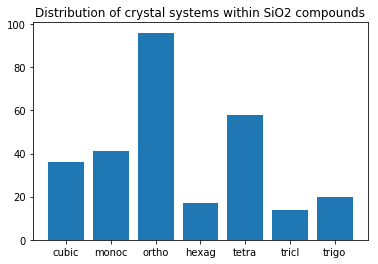

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

with MPRester() as mpr:
    # Collect all the entries for SiO2
    results = mpr.query(criteria={"pretty_formula":'SiO2'}, 
                 properties=["material_id", "spacegroup.crystal_system"])

    # Collect the crystal systems into a list and count them
    systems = [r["spacegroup.crystal_system"] for r in results]
    count_dict = {}
    for system in systems:
        if system in count_dict:
            count_dict[system] += 1
        else:
            count_dict[system] = 1
            
    # Plot the distribution
    plt.bar(range(len(count_dict)), count_dict.values(), align='center')
    plt.xticks(range(len(count_dict)), [key[0:5] for key in list(count_dict.keys())])
    plt.title('Distribution of crystal systems within SiO2 compounds')
    plt.show()

***
## Section 4: Using the MPRester and Pymatgen to Find Materials With Exotic Mechanical Properties

The tetragonal SiO$_2$ polymorph $\alpha$-cristobalite is one of the very few crystalline materials known to have a negative average Poisson's ratio, which means that its cross-section expands under tensile strain rather than contracting. This property can be extremely useful in a variety of applications such as scratch-resistant coatings and high-toughness ceramics. 

Why does $\alpha$-cristobalite exhibit this property while other materials do not? The prevailing hypothesis is that $\alpha$-cristobalite's negative Poisson's ratio is a result of its crystal structure. If that's the case, then perhaps we can find other materials with this exotic property by looking for materials with similar structures and then calculating their Poisson's ratios.

First, we should find the structure for $\alpha$-cristobalite that represent materials that are likely to be synthesizable (e_above_hull < 25 meV):

In [9]:
with MPRester() as mpr:
    results = mpr.query({'pretty_formula':'SiO2', 'e_above_hull':{"$lte":0.025}}, 
                        ['material_id', 'structure', 'spacegroup','tags'])
    print(len(results))

160


This might be too many to go through by hand. Let's add a [regex](https://en.wikipedia.org/wiki/Regular_expression) query for 'cristobalite':

In [104]:
with MPRester() as mpr:
    results = mpr.query({'pretty_formula':'SiO2', 'e_above_hull':{"$lte":0.025}, 
                         'tags':{'$regex':'cristobalite'}}, 
                        ['material_id', 'structure', 'spacegroup','tags'])
    print(len(results))

1


In [106]:
ac = results[0]

We found [(mp-6945)](https://materialsproject.org/materials/mp-6945/), the right material!

In [6]:
# ac_structure = [your code here]
# print(ac_structure)
ac_structure = mpr.get_structure_by_material_id("mp-6945")
print(ac_structure)

Full Formula (Si4 O8)
Reduced Formula: SiO2
abc   :   5.082618   5.082618   7.095207
angles:  90.000000  90.000000  90.000000
Sites (12)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  O     0.905861  0.75898   0.325631
  1  O     0.094139  0.24102   0.825631
  2  O     0.75898   0.905861  0.674369
  3  O     0.258979  0.594139  0.075631
  4  O     0.24102   0.094139  0.174369
  5  O     0.405861  0.74102   0.424369
  6  O     0.594139  0.258979  0.924369
  7  O     0.74102   0.405861  0.575631
  8  Si    0.705544  0.705544  0.5
  9  Si    0.794456  0.205544  0.75
 10  Si    0.205544  0.794456  0.25
 11  Si    0.294456  0.294456  0


***
### Quick Aside About MongoDB Query Operators

Above, we specified the chemical formula SiO$_2$ for our query. This is an example of, the "specify" operator. However, MongoDB's syntax also includes other [query operators](https://docs.mongodb.com/manual/reference/operator/query/#query-selectors), allowing us to bulid complex conditionals into our queries. 

A recent paper by McEnany et. al. proposes a novel ammonia synthesis process based on the electrochemical cycling of lithium ([link](http://pubs.rsc.org/en/content/articlelanding/2017/ee/c7ee01126a#!divAbstract)). As an exercise, let's use some of MongoDB's operators and ask the database for nitrides of alkali metals.

In [111]:
alkali_metals = ['Li', 'Na', 'K', 'Rb', 'Cs']

criteria={"elements":{"$in":alkali_metals, "$all": ["N"]}, "nelements":2}
# criteria={"$and":[{"elements":{"$in":alkali_metals}},{"elements":{"$all": ["N"]}}]}
properties=['material_id', 'pretty_formula']

mpr.query(criteria, properties)

[{'material_id': 'mp-634410', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-999496', 'pretty_formula': 'Na3N'},
 {'material_id': 'mp-22003', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-2341', 'pretty_formula': 'Li3N'},
 {'material_id': 'mp-11801', 'pretty_formula': 'K3N'},
 {'material_id': 'mp-636056', 'pretty_formula': 'KN3'},
 {'material_id': 'mp-2251', 'pretty_formula': 'Li3N'},
 {'material_id': 'mp-1009221', 'pretty_formula': 'NaN'},
 {'material_id': 'mp-581833', 'pretty_formula': 'RbN3'},
 {'material_id': 'mp-1059612', 'pretty_formula': 'LiN'},
 {'material_id': 'mp-570538', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-510557', 'pretty_formula': 'CsN3'},
 {'material_id': 'mp-1064119', 'pretty_formula': 'KN'},
 {'material_id': 'mp-1066400', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-1058689', 'pretty_formula': 'KN'},
 {'material_id': 'mp-1062345', 'pretty_formula': 'Li2N'},
 {'material_id': 'mp-1064161', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-1064529', 'pretty

For convenience, the MPRester also accepts a simplified syntax for queries by chemical system. For example, the query we made above can be simplified to:

In [10]:
mpr.query('{Li,Na,K,Rb,Cs}-N', ['material_id', 'pretty_formula'])

[{'material_id': 'mp-510557', 'pretty_formula': 'CsN3'},
 {'material_id': 'mp-827', 'pretty_formula': 'KN3'},
 {'material_id': 'mp-636056', 'pretty_formula': 'KN3'},
 {'material_id': 'mp-11801', 'pretty_formula': 'K3N'},
 {'material_id': 'mp-2659', 'pretty_formula': 'LiN3'},
 {'material_id': 'mp-2341', 'pretty_formula': 'Li3N'},
 {'material_id': 'mp-2251', 'pretty_formula': 'Li3N'},
 {'material_id': 'mp-1009221', 'pretty_formula': 'NaN'},
 {'material_id': 'mp-634410', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-22003', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-999495', 'pretty_formula': 'Na3N'},
 {'material_id': 'mp-570538', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-999496', 'pretty_formula': 'Na3N'},
 {'material_id': 'mp-22777', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-2639', 'pretty_formula': 'Na3N'},
 {'material_id': 'mp-743', 'pretty_formula': 'RbN3'},
 {'material_id': 'mp-581833', 'pretty_formula': 'RbN3'}]

We can also perform the same query, but ask the database to only return compounds with energies above the hull less than 10 meV/atom by using the "less than" operator, "`$lt`". (The energy above the convex hull gives us a sense of how stable a compound is relative to other compounds with the same composition.) 

In [11]:
criteria={"elements":{"$in":alkali_metals, "$all":["N"]}, "nelements":2, 
          'e_above_hull':{"$lt":0.010}}
properties=['material_id', 'pretty_formula']
mpr.query(criteria, properties)

[{'material_id': 'mp-2659', 'pretty_formula': 'LiN3'},
 {'material_id': 'mp-827', 'pretty_formula': 'KN3'},
 {'material_id': 'mp-2341', 'pretty_formula': 'Li3N'},
 {'material_id': 'mp-743', 'pretty_formula': 'RbN3'},
 {'material_id': 'mp-2251', 'pretty_formula': 'Li3N'},
 {'material_id': 'mp-22003', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-570538', 'pretty_formula': 'NaN3'},
 {'material_id': 'mp-510557', 'pretty_formula': 'CsN3'}]

Now, let's get back to our example of finding materials with similar crystal structures to $\alpha$-cristobalite. 

***

For our search, we want to start with a set of structures that are:
* Computationally tractable (not too many sites)
* Not too unlikely to be synthesizable (small energy above hull, i.e. <100 meV)

Let's construct this query:

In [13]:
criteria={'nsites':{'$lte':50}, 'e_above_hull':{'$lte':0.100}}
properties=['material_id', 'spacegroup']

data = mpr.query(criteria,properties)

print([d['material_id'] for d in data[20000:20020]])

['mp-1357', 'mp-23219', 'mp-11416', 'mp-21030', 'mp-22460', 'mp-749', 'mp-1751', 'mp-19962', 'mp-11412', 'mp-530', 'mp-7631', 'mp-680570', 'mp-12608', 'mp-2772', 'mp-1463', 'mp-2033', 'mp-611', 'mp-861975', 'mp-2715', 'mp-619']


The next step is to compare all of these materials to $\alpha$-cristobalite. We'll need something that can tell us whether two structures are similar. Luckily for us, the pymatgen StructureMatcher does just that!

In [14]:
from pymatgen.analysis.structure_matcher import StructureMatcher

sm = StructureMatcher()
ac_structure = mpr.get_structure_by_material_id("mp-6945")

print(sm.fit(ac_structure, ac_structure))

True


We know that the high-temperature phase of cristobalite, $\beta$-cristobalite [(mp-546794)](https://materialsproject.org/materials/mp-546794/), has a very similar structure to $\alpha$-cristobalite. Let's see if the structure matcher agrees.

In [15]:
bc_structure = mpr.get_structure_by_material_id("mp-546794")

print(sm.fit(ac_structure, bc_structure))

False


Unfortunately, the default settings of the structure matcher are too strict for our purposes. We want a comparison engine that will return True if two structures are similar to each other, not just those that are exactly the same. 

To solve this problem, we can instantiate our comparison engine with looser tolerances and use a species-agnostic FrameworkComparator from pymatgen, which allows us to compare structures across different chemistries.

In [16]:
from pymatgen.analysis.structure_matcher import FrameworkComparator

comparison_engine = StructureMatcher(ltol=.2, stol=.5, angle_tol=10, primitive_cell=True, scale=True, 
                                     attempt_supercell=True, comparator=FrameworkComparator())


In [17]:
bc_structure = mpr.get_structure_by_material_id("mp-546794")

print(comparison_engine.fit(ac_structure, bc_structure))

True


Just to make sure we haven't increased the tolerances too much, let's try it against a random compound to make sure it's not matching un-similar structures. 

In [18]:
random_structure = mpr.get_structure_by_material_id("mp-4991")
print(comparison_engine.fit(ac_structure, random_structure))

False


Now, let's get back to our example of finding materials with similar crystal structures to $\alpha$-cristobalite. 
***

Imagine that we have an experimental colleague, Soren Tsarpinski, who is an expert at synthesizing vanadate compounds. We have a hunch that some of the vanadates coming out of Dr. Tsarpinski's lab might have similar structures to $\alpha$-cristobalite and therefore might have negative Poisson's ratios. Let's see if we're right:

In [21]:
vanadates = mpr.query('*V3O8', ['material_id', 'structure', 'pretty_formula'])
[v['pretty_formula'] for v in vanadates]

/opt/conda/lib/python3.5/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/opt/conda/lib/python3.5/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/opt/conda/lib/python3.5/site-packages/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


['BaV3O8',
 'CsV3O8',
 'KV3O8',
 'LiV3O8',
 'LiV3O8',
 'LiV3O8',
 'LiV3O8',
 'LiV3O8',
 'MgV3O8',
 'MgV3O8',
 'MnV3O8',
 'MnV3O8',
 'NaV3O8',
 'NaV3O8',
 'NbV3O8',
 'NbV3O8',
 'RbV3O8',
 'TiV3O8',
 'TlV3O8',
 'V3CoO8',
 'V3CoO8',
 'V3CoO8',
 'V3CoO8',
 'V3CrO8',
 'V3CuO8',
 'V3CuO8',
 'V3FeO8',
 'V3FeO8',
 'V3FeO8',
 'V3NiO8',
 'V3NiO8',
 'V3SnO8',
 'V3ZnO8']

In [22]:
matches = []
for v in vanadates:
    if comparison_engine.fit(ac_structure, v['structure']):
        matches.append(v['material_id'])


criteria = {"material_id":{"$in":matches}}
properties = ['material_id', 'pretty_formula', 'elasticity.homogeneous_poisson']

possible_candidates = mpr.query(criteria, properties)
    
possible_candidates

[{'elasticity.homogeneous_poisson': -0.04,
  'material_id': 'mp-766784',
  'pretty_formula': 'V3CoO8'},
 {'elasticity.homogeneous_poisson': None,
  'material_id': 'mp-771790',
  'pretty_formula': 'V3NiO8'},
 {'elasticity.homogeneous_poisson': -0.06,
  'material_id': 'mp-775001',
  'pretty_formula': 'V3FeO8'},
 {'elasticity.homogeneous_poisson': 0.08,
  'material_id': 'mp-776985',
  'pretty_formula': 'MnV3O8'}]